# **1. Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

# TDA
import kmapper as km
import dyneusr as dsr
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import DBSCAN
from kmapper.cover import Cover
from tmap.tda.utils import optimize_dbscan_eps

In [2]:
# Set seed for reproducibility
seed_value = 27
random.seed(seed_value)

# **2. Import data**

In [3]:
data_path = '/Users/stefanovannoni/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Dottorato/Tesi Magistrale/data.csv'

# Load data
data = pd.read_csv(data_path)

# Remove class labels
x = data.drop('study_group', axis=1)

# Class labels
y = data['study_group']
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.astype(int)

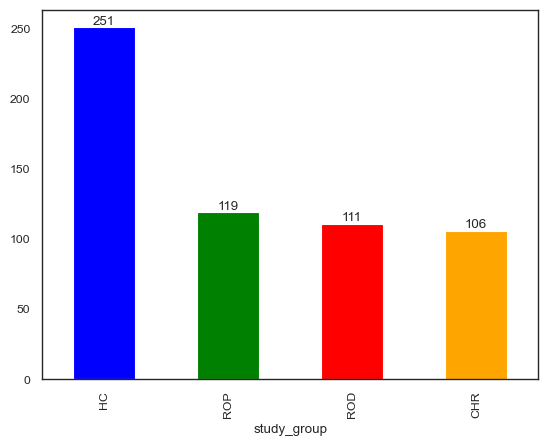

In [6]:
# Class labels histogram
labels_freq = data['study_group'].value_counts()
colors = ['blue', 'green', 'red', 'orange']
labels_freq.plot(kind='bar', color=colors)

for i, valore in enumerate(labels_freq):
    plt.text(i, valore, str(valore), ha='center', va='bottom')

plt.show()

In [7]:
# Only HC samples
x_hc = data[data['study_group'] == 'HC']
x_hc = x_hc.drop('study_group', axis=1)

# **3. Project data (Filtering)**

In [8]:
# PCA
pca = PCA(n_components=2, random_state=seed_value)
pca = pca.fit(x_hc)

# Isomap
isomap = Isomap(n_components=2)
isomap = isomap.fit(x_hc)

# Kernel PCA
kernelpca = KernelPCA(n_components=2, kernel='rbf', random_state=seed_value)
kernelpca = kernelpca.fit(x_hc)

In [9]:
# Projection into 2D
x_hc_pca = pca.transform(x_hc)
x_hc_isomap = isomap.transform(x_hc)
x_hc_kernelpca = kernelpca.transform(x_hc)

# **4. TDA**

In [10]:
mapper = km.KeplerMapper(verbose=1)

KeplerMapper()


In [11]:
# Create lens function
lens_pca = mapper.fit_transform(pca.fit_transform(x_hc, y=None), projection=[0,1])
lens_isomap = mapper.fit_transform(isomap.fit_transform(x_hc, y=None), projection=[0,1])
lens_kernelpca = mapper.fit_transform(kernelpca.fit_transform(x_hc, y=None), projection=[0,1])

# Create cover
cover = Cover(n_cubes=20, perc_overlap=0.5)

..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (251, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (251, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (251, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()



In [12]:
# Create graph
graph_pca = mapper.map(
    lens=lens_pca,
    X=x_hc,
    cover=cover,
    clusterer=DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=2)
)

graph_isomap = mapper.map(
    lens=lens_isomap,
    X=x_hc,
    cover=cover,
    clusterer=DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=2)
)

graph_kernelpca = mapper.map(
    lens=lens_kernelpca,
    X=x_hc,
    cover=cover,
    clusterer=DBSCAN(eps=optimize_dbscan_eps(x_hc, threshold=95), min_samples=2)
)

Mapping on data shaped (251, 12720) using lens shaped (251, 2)

Creating 400 hypercubes.

Created 274 edges and 96 nodes in 0:00:00.132147.
Mapping on data shaped (251, 12720) using lens shaped (251, 2)

Creating 400 hypercubes.

Created 348 edges and 138 nodes in 0:00:00.146566.
Mapping on data shaped (251, 12720) using lens shaped (251, 2)

Creating 400 hypercubes.

Created 413 edges and 152 nodes in 0:00:00.145526.


In [13]:
# Convert graphs to networkx
graph_pca_nx = km.adapter.to_nx(graph_pca)
graph_isomap_nx = km.adapter.to_nx(graph_isomap)
graph_kernelpca_nx = km.adapter.to_nx(graph_kernelpca)

In [14]:
# PCA
samples_in_nodes_pca = {name: attributes['membership'] for name, attributes in list(graph_pca_nx.nodes(data=True))}
samples_in_nodes_pca = list(samples_in_nodes_pca.values())
samples_pca = [int(el_pca.split('cube')[1].split('_')[0]) for el_pca in list(graph_pca_nx.nodes())]

# Isomap
samples_in_nodes_isomap = {name: attributes['membership'] for name, attributes in list(graph_isomap_nx.nodes(data=True))}
samples_in_nodes_isomap = list(samples_in_nodes_isomap.values())
samples_isomap = [int(el_isomap.split('cube')[1].split('_')[0]) for el_isomap in list(graph_isomap_nx.nodes())]

# Kernel PCA
samples_in_nodes_kernelpca = {name: attributes['membership'] for name, attributes in list(graph_kernelpca_nx.nodes(data=True))}
samples_in_nodes_kernelpca = list(samples_in_nodes_kernelpca.values())
samples_kernelpca = [int(el_kernelpca.split('cube')[1].split('_')[0]) for el_kernelpca in list(graph_kernelpca_nx.nodes())]

# **5. Framework validation**

In [15]:
def mapping_tda(data, sample, cover):
    indices = np.arange(data.shape[0])[:, np.newaxis]
    data = np.hstack((indices, data))

    cube_centers = cover.fit(data)
    cube_centers = [(sublist[0], sublist[1]) for sublist in cube_centers]

    hyper_cubes = cover.transform(data, cube_centers)

    index_cubes = cover.find(sample)

    hyper_cubes_index = []
    for index in index_cubes:
        cube = cover.transform_single(data, cube_centers[index])

        for j in range(len(hyper_cubes)):
            if np.array_equal(cube, hyper_cubes[j]):
                hyper_cubes_index.append(j)

    for k in hyper_cubes_index:
        if len(hyper_cubes[k]) == 1:
            print(f'Hyper cube {k} with only one sample')
        else:
            continue

    return hyper_cubes_index, hyper_cubes, cube_centers

## **5.1. PCA filter projection**

In [16]:
# Project HC samples
sample_map_pca = []

for i in range(len(x_hc)):
    subject = x_hc.iloc[i, :].values.reshape(1, -1)
    subject_pca = pca.transform(subject)
    hyper_cubes_index_pca, hyper_cubes_pca, cube_centers_pca = mapping_tda(x_hc_pca, subject_pca, cover)

    for cube_index in hyper_cubes_index_pca:
        if len(hyper_cubes_pca[cube_index]) > 1:
            if cube_index in samples_pca and f'subject_{i}' not in sample_map_pca:
                sample_map_pca.append(f'subject_{i}')

Hyper cube 54 with only one sample
Hyper cube 73 with only one sample
Hyper cube 74 with only one sample
Hyper cube 54 with only one sample
Hyper cube 73 with only one sample
Hyper cube 74 with only one sample
Hyper cube 54 with only one sample
Hyper cube 73 with only one sample
Hyper cube 74 with only one sample
Hyper cube 105 with only one sample
Hyper cube 75 with only one sample
Hyper cube 91 with only one sample
Hyper cube 92 with only one sample
Hyper cube 106 with only one sample
Hyper cube 107 with only one sample
Hyper cube 91 with only one sample
Hyper cube 92 with only one sample
Hyper cube 106 with only one sample
Hyper cube 107 with only one sample
Hyper cube 91 with only one sample
Hyper cube 92 with only one sample
Hyper cube 106 with only one sample
Hyper cube 107 with only one sample
Hyper cube 91 with only one sample
Hyper cube 92 with only one sample
Hyper cube 106 with only one sample
Hyper cube 107 with only one sample
Hyper cube 115 with only one sample
Hyper cube

In [17]:
miss_indexes = [f'subject_{i}' for i in range(251) if f'subject_{i}' not in sample_map_pca]
miss_indexes = [int(element.split('subject_')[1].split('_')[0]) for element in miss_indexes]

In [18]:
miss_indexes_set = set(miss_indexes)
count = sum(valore in sample for sample in samples_in_nodes_pca for valore in miss_indexes_set)

print(count)

0


## **5.2. Isomap filter projection**

In [22]:
# Project HC samples
isomap_sample_map = []

for i in range(len(x_hc)):
    subject = x_hc.iloc[i, :].values.reshape(1, -1)
    subject_isomap = isomap.transform(subject)
    hyper_cubes_index_isomap, hyper_cubes_isomap, cube_centers_isomap = mapping_tda(x_hc_isomap, subject_isomap, cover)

    for cube_index in hyper_cubes_index_isomap:
        if len(hyper_cubes_isomap[cube_index]) > 1:
            if cube_index in samples_isomap and f'subject_{i}' not in isomap_sample_map:
                isomap_sample_map.append(f'subject_{i}')

Hyper cube 165 with only one sample
Hyper cube 166 with only one sample
Hyper cube 165 with only one sample
Hyper cube 166 with only one sample
Hyper cube 76 with only one sample
Hyper cube 38 with only one sample
Hyper cube 186 with only one sample
Hyper cube 43 with only one sample
Hyper cube 90 with only one sample
Hyper cube 25 with only one sample
Hyper cube 26 with only one sample
Hyper cube 25 with only one sample
Hyper cube 26 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 117 with only one sample
Hyper cube 118 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 117 with only one sample
Hyper cube 118 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 117 with only one sample
Hyper cube 118 with only one sample
Hyper cube 97 with only one sample
Hyper cube 98 with only one sample
Hyper cube 117 with only one sample
Hyper cu

In [23]:
miss_indexes = [f'subject_{i}' for i in range(251) if f'subject_{i}' not in isomap_sample_map]
miss_indexes = [int(element.split('subject_')[1].split('_')[0]) for element in miss_indexes]

In [25]:
miss_indexes_set = set(miss_indexes)
count = sum(valore in sample for sample in samples_in_nodes_isomap for valore in miss_indexes_set)

print(count)

0


## **5.3. Kernel PCA filter projection**

In [26]:
# Project HC samples
kernelpca_sample_map = []

for i in range(len(x_hc)):
    subject = x_hc.iloc[i, :].values.reshape(1, -1)
    subject_kernelpca = kernelpca.transform(subject)
    hyper_cubes_index_kernelpca, hyper_cubes_kernelpca, cube_centers_kernelpca = mapping_tda(x_hc_kernelpca, subject_kernelpca, cover)

    for cube_index in hyper_cubes_index_kernelpca:
        if len(hyper_cubes_kernelpca[cube_index]) > 1:
            if cube_index in samples_kernelpca and f'subject_{i}' not in kernelpca_sample_map:
                kernelpca_sample_map.append(f'subject_{i}')

Hyper cube 183 with only one sample
Hyper cube 192 with only one sample
Hyper cube 207 with only one sample
Hyper cube 192 with only one sample
Hyper cube 207 with only one sample
Hyper cube 218 with only one sample
Hyper cube 86 with only one sample
Hyper cube 87 with only one sample
Hyper cube 86 with only one sample
Hyper cube 87 with only one sample
Hyper cube 221 with only one sample
Hyper cube 222 with only one sample
Hyper cube 229 with only one sample
Hyper cube 230 with only one sample
Hyper cube 221 with only one sample
Hyper cube 222 with only one sample
Hyper cube 229 with only one sample
Hyper cube 230 with only one sample
Hyper cube 221 with only one sample
Hyper cube 222 with only one sample
Hyper cube 229 with only one sample
Hyper cube 230 with only one sample
Hyper cube 221 with only one sample
Hyper cube 222 with only one sample
Hyper cube 229 with only one sample
Hyper cube 230 with only one sample
Hyper cube 69 with only one sample
Hyper cube 83 with only one sampl

In [27]:
miss_indexes = [f'subject_{i}' for i in range(251) if f'subject_{i}' not in kernelpca_sample_map]
miss_indexes = [int(element.split('subject_')[1].split('_')[0]) for element in miss_indexes]

In [30]:
miss_indexes_set = set(miss_indexes)
count = sum(valore in sample for sample in samples_in_nodes_kernelpca for valore in miss_indexes_set)

print(count)

0
